<a href="https://colab.research.google.com/github/damianmtz98/Datos_Masivos_MCD/blob/main/P3.AnalisisDeSentimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis de Sentimiento insultos a Donald Trump en Twitter**

In [ ]:
import numpy as np
import pandas as pd
import string
import re
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import matplotlib.dates as mdates
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

In [29]:
df = pd.read_csv('trump tw.csv')
df.head()

,Unnamed: 0,date,target,insult,tweet
0,1,09/10/2014,thomas-frieden,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2,09/10/2014,thomas-frieden,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,3,16/06/2015,politicians,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...
3,4,24/06/2015,ben-cardin,It's politicians like Cardin that have destroy...,Politician @SenatorCardin didn't like that I s...
4,5,24/06/2015,neil-young,total hypocrite,"For the nonbeliever, here is a photo of @Neily..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10360 entries, 0 to 10359
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10360 non-null  int64 
 1   date        10360 non-null  object
 2   target      10358 non-null  object
 3   insult      10360 non-null  object
 4   tweet       10360 non-null  object
dtypes: int64(1), object(4)
memory usage: 404.8+ KB


In [6]:
tweets = df[['date', 'insult','tweet']]
tweets.columns = ['fecha', 'insulto','tweet']
tweets['fecha'] = pd.to_datetime(tweets['fecha'], infer_datetime_format=True)
tweets['fecha'] = tweets['fecha'].dt.strftime('%Y-%m-%d')
tweets.head(3)

,fecha,insulto,tweet
0,2014-09-10,fool,"Can you believe this fool, Dr. Thomas Frieden ..."
1,2014-09-10,DOPE,"Can you believe this fool, Dr. Thomas Frieden ..."
2,2015-06-16,all talk and no action,Big time in U.S. today - MAKE AMERICA GREAT AG...


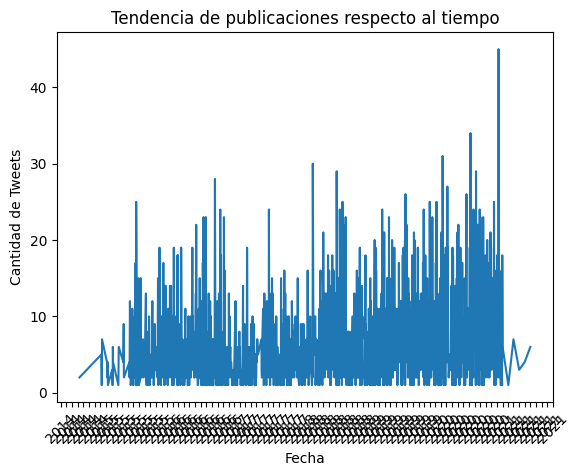

In [8]:

conteo_tweets = Counter(tweets.fecha)
fechas_unicas = sorted(conteo_tweets.keys())
cantidad_tweets = [conteo_tweets[fecha] for fecha in fechas_unicas]
fechas_unicas = [datetime.strptime(fecha, "%Y-%m-%d") for fecha in fechas_unicas]
plt.plot(fechas_unicas, cantidad_tweets)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Tweets')
plt.title('Tendencia de publicaciones respecto al tiempo')
plt.xticks(rotation=45)
plt.show()

In [15]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    nuevo_texto = texto.lower()
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    regex = '[\!\"\#\$\%\&\\\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^_\`\{\|\}\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    nuevo_texto = re.sub("\s+", ' ', nuevo_texto)
    nuevo_texto = nuevo_texto.split(sep = ' ')
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)
test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(texto=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', "l'limpieza", 'de', 'texto', '@cienciadedatos', '#textmining']


In [17]:

tweets['tweet_tokenizado'] = tweets['tweet'].apply(lambda x: limpiar_tokenizar(x))
tweets[['tweet', 'tweet_tokenizado']].head()

,tweet,tweet_tokenizado
0,"Can you believe this fool, Dr. Thomas Frieden ...","[can, you, believe, this, fool,, dr., thomas, ..."
1,"Can you believe this fool, Dr. Thomas Frieden ...","[can, you, believe, this, fool,, dr., thomas, ..."
2,Big time in U.S. today - MAKE AMERICA GREAT AG...,"[big, time, in, u.s., today, make, america, gr..."
3,Politician @SenatorCardin didn't like that I s...,"[politician, @senatorcardin, didn't, like, tha..."
4,"For the nonbeliever, here is a photo of @Neily...","[for, the, nonbeliever,, here, is, photo, of, ..."


In [18]:

tweets_tidy = tweets.explode(column='tweet_tokenizado')
tweets_tidy = tweets_tidy.drop(columns='tweet')
tweets_tidy = tweets_tidy.rename(columns={'tweet_tokenizado':'token'})
tweets_tidy.head(3)

,fecha,insulto,token
0,2014-09-10,fool,can
0,2014-09-10,fool,you
0,2014-09-10,fool,believe


In [20]:
temp_df = pd.DataFrame(tweets_tidy.groupby("insulto")["token"].count())
mean_length = temp_df["token"].mean()
std_length = temp_df["token"].std()

print("Longitud media de los tweets:", mean_length)
print("Desviación de los tweets:", std_length)

Longitud media de los tweets: 51.22113241194828
Desviación de los tweets: 229.81337066875548


In [21]:
nltk.download('stopwords')

stop_words = list(stopwords.words('english'))

stop_words.extend(("amp", "xa", "xe"))
print(stop_words[:10])


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:

tweets_tidy = tweets_tidy[~(tweets_tidy["token"].isin(stop_words))]


In [23]:

lexicon = pd.read_table(
            'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
            names = ['termino', 'sentimiento']
          )
lexicon.head()

,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [25]:
# Sentimiento promedio de cada tweet
tweets_sentimientos = pd.merge(
                            left     = tweets_tidy,
                            right    = lexicon,
                            left_on  = "token",
                            right_on = "termino",
                            how      = "inner"
                      )

tweets_sentimientos = tweets_sentimientos.drop(columns = "termino")
tweets_sentimientos = tweets_sentimientos[["fecha", "insulto", "sentimiento"]] \
                      .groupby(["fecha", "insulto"])\
                      .sum().reset_index()
tweets_sentimientos.head()


,fecha,insulto,sentimiento
0,2014-09-10,DOPE,-2
1,2014-09-10,fool,-2
2,2015-01-07,racists,-2
3,2015-01-07,"terrible governor of NY, one of the worst",-6
4,2015-01-07,they 'racial profile' all over the place,0


In [26]:

print(f"Positivos: {round(100 * np.mean(tweets_sentimientos.sentimiento > 0), 2)}")
print(f"Neutros  : {round(100 * np.mean(tweets_sentimientos.sentimiento == 0), 2)}")
print(f"Negativos: {round(100 * np.mean(tweets_sentimientos.sentimiento < 0), 2)}")

Positivos: 24.68
Neutros  : 6.28
Negativos: 69.04


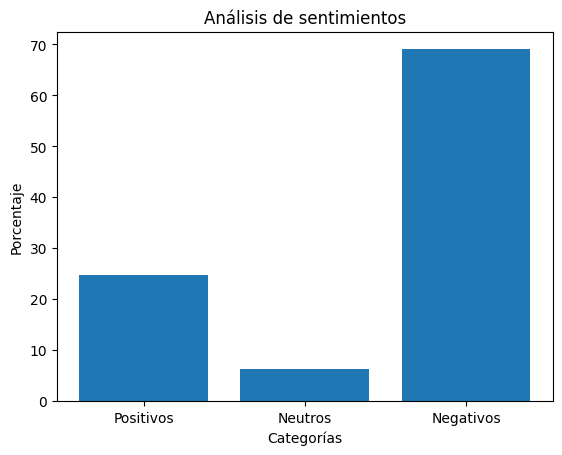

In [28]:
positivos = 24.68
neutros = 6.28
negativos = 69.04

resultados = [positivos, neutros, negativos]
etiquetas = ['Positivos', 'Neutros', 'Negativos']


plt.bar(etiquetas, resultados)


plt.title('Análisis de sentimientos')
plt.xlabel('Categorías')
plt.ylabel('Porcentaje')


plt.show()